In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cpu')

In [2]:
import cv2

from yolort.utils.image_utils import (
    letterbox,
    non_max_suppression,
    plot_one_box,
    scale_coords,
    color_list,
)
from yolort.utils import (
    cv2_imshow,
    get_image_from_url,
    read_image_to_tensor,
    update_module_state_from_ultralytics,
)

## Prepare image and model weights to test

In [3]:
is_half = False

# img_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/master/test/assets/zidane.jpg"
img_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/test/assets/zidane.jpg"
img_raw = get_image_from_url(img_path)

yolort_weight_path = './yolov5s_r40_updated.pt'
ultralytics_weights_path = "./yolov5s.pt"

You can download the weight with following methods

```python
torch.hub.download_url_to_file(
    r'https://github.com/ultralytics/yolov5/releases/download/v4.0/yolov5s.pt',
    ultralytics_weights_path,
    progress=True,
)
```

In [4]:
# Preprocess
img = letterbox(img_raw, new_shape=(640, 640))[0]
img = read_image_to_tensor(img, is_half)
img = img.to(device)

## Load model as ultralytics and inference

In [5]:
conf = 0.25
iou = 0.45

model = torch.hub.load('ultralytics/yolov5', 'custom', path=ultralytics_weights_path, autoshape=False)
model = model.to(device)
model.conf = conf  # confidence threshold (0-1)
model.iou = iou  # NMS IoU threshold (0-1)
model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
model.eval()

# Get actual anchors from ultralytics model
m = model.model[-1]  # get Detect() layer
anchor_grids = m.anchor_grid.view((3, -1)).cpu().tolist()  # get anchors

with torch.no_grad():
    ultralytics_dets = model(img[None])[0]
    ultralytics_dets = non_max_suppression(ultralytics_dets, conf, iou, agnostic=True)[0]

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
YOLOv5 🚀 v5.0-189-gdaab682 torch 1.7.1 CUDA:0 (Tesla P100-SXM2-16GB, 16276.25MB)



In [6]:
print(f'Detection results with ultralytics:\n{ultralytics_dets}')

Detection results with ultralytics:
tensor([[3.75445e+02, 3.40445e+01, 5.79386e+02, 3.67594e+02, 8.24506e-01, 0.00000e+00],
        [5.83124e+01, 1.11402e+02, 5.32394e+02, 3.68957e+02, 5.73824e-01, 0.00000e+00],
        [2.08478e+02, 2.26613e+02, 2.58293e+02, 3.70514e+02, 5.63577e-01, 2.70000e+01]])


## Updating model weights from ultralytics to yolort

In [7]:
model = update_module_state_from_ultralytics(arch='yolov5s',
                                             version='v4.0',
                                             custom_path_or_model=ultralytics_weights_path,
                                             set_fp16=is_half,
                                             num_classes=80)

# The updated model checkpoint
torch.save(model.state_dict(), yolort_weight_path)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_v4.0

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                     

## Load model as yolort and inference

Note: you should check the `anchor_grids` carefully here, because value of `anchor_grids` will be autoenvolved when you train a custom model with ultralytics.

In [8]:
from yolort.models.yolo import yolov5_darknet_pan_s_r40 as yolov5s

model = yolov5s(score_thresh=conf, nms_thresh=iou, num_classes=80, anchor_grids=anchor_grids)
model.load_state_dict(torch.load(yolort_weight_path))
model = model.to(device)

model.eval()

with torch.no_grad():
    yolort_dets = model(img[None])

In [9]:
print(f"Detection boxes with yolort:\n{yolort_dets[0]['boxes']}")

Detection boxes with yolort:
tensor([[375.44550,  34.04448, 579.38599, 367.59357],
        [ 58.31236, 111.40195, 532.39380, 368.95679],
        [208.47757, 226.61272, 258.29257, 370.51349]])


In [10]:
print(f"Detection scores with yolort:\n{yolort_dets[0]['scores']}")

Detection scores with yolort:
tensor([0.82451, 0.57382, 0.56358])


In [11]:
print(f"Detection labels with yolort:\n{yolort_dets[0]['labels']}")

Detection labels with yolort:
tensor([ 0,  0, 27])


## Varify the detection results between yolort and ultralytics

In [12]:
# Testing boxes
torch.testing.assert_allclose(
    yolort_dets[0]['boxes'], ultralytics_dets[:, :4], rtol=1e-05, atol=1e-07)
# Testing scores
torch.testing.assert_allclose(
    yolort_dets[0]['scores'], ultralytics_dets[:, 4], rtol=1e-05, atol=1e-07)
# Testing labels
torch.testing.assert_allclose(
    yolort_dets[0]['labels'], ultralytics_dets[:, 5].to(dtype=torch.int64), rtol=1e-05, atol=1e-07)

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Detection output visualisation

In [13]:
# Get label names
import requests

# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/master/notebooks/assets/coco.names"
label_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/notebooks/assets/coco.names"
response = requests.get(label_path)
names = response.text

LABELS = []

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

The labels can also be obtained by

```python
from yolort.utils.image_utils import load_names
labels = load_names('./assets/coco.names')
```

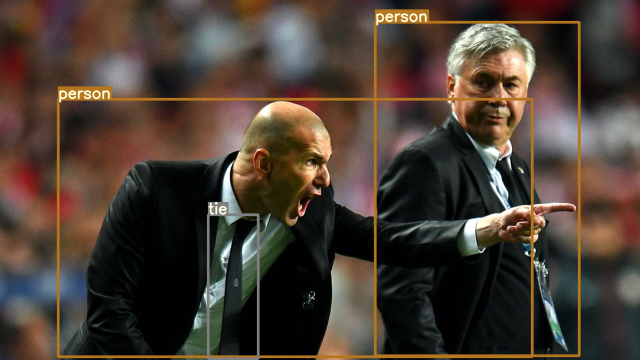

In [14]:
# Hah, that's the trick to rescale the box correctly
boxes = scale_coords(yolort_dets[0]['boxes'], img.shape[1:], img_raw.shape[:-1])

for box, label in zip(boxes.tolist(), yolort_dets[0]['labels'].tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)